# 3D AMRVAC snapshot

We create a Magritte model form a snapshot of 3D AMRVAC hydrodynamics simulation.

## Setup

Import the required functionalty.

In [2]:
import magritte.setup as setup                         # Model setup
import magritte.core  as magritte                      # Core functionality
import vtk                                             # Reading the model
import numpy as np                                     # Data structures
import warnings                                        # Hide warnings
warnings.filterwarnings('ignore')                      # especially for yt
import yt                                              # 3D plotting

from tqdm                   import tqdm                # Progress bars
from astropy                import constants           # Unit conversions
from vtk.util.numpy_support import vtk_to_numpy        # Converting data
from scipy.spatial          import Delaunay, cKDTree   # Finding neighbors
from yt.funcs               import mylog               # To avoid yt output 
mylog.setLevel(40)                                     # as error messages

Define a working directory (you will have to change this).

In [1]:
wdir = "/home/frederik/Magritte-examples/AMRVAC_3D/"

Create the working directory.

In [3]:
!mkdir -p $wdir

Define file names.

In [4]:
input_file = f'{wdir}model_AMRVAC_3D.vtu'    # AMRVAC snapshot
model_file = f'{wdir}model_AMRVAC_3D.hdf5'   # Resulting Magritte model
lamda_file = f'{wdir}co.txt'                 # Line data file

We use a snapshot and data file that can be downloaded with the following links.

In [5]:
input_link = "https://owncloud.ster.kuleuven.be/index.php/s/mqtDyDSMPm2TjmG/download"
lamda_link = "https://home.strw.leidenuniv.nl/~moldata/datafiles/co.dat"

Dowload the snapshot and the linedata (``%%capture`` is just used to suppress the output).

In [6]:
%%capture
!wget $input_link --output-document $input_file
!wget $lamda_link --output-document $lamda_file

## Extract data

The script below extract the required data from the snapshot `.vtu` file.

In [7]:
# Create a vtk reader to read the AMRVAC file and extract its contents.
reader = vtk.vtkXMLUnstructuredGridReader()
reader.SetFileName(input_file)
reader.Update()

# Extract the grid output
grid = reader.GetOutput()

# Extract the number of cells
ncells = grid.GetNumberOfCells() 

# Extract cell data
cellData = grid.GetCellData()
for i in tqdm(range(cellData.GetNumberOfArrays())):
    array = cellData.GetArray(i)
    if (array.GetName() == 'rho'):
        rho = vtk_to_numpy(array)
    if (array.GetName() == 'temperature'):
        tmp = vtk_to_numpy(array)
    if (array.GetName() == 'v1'):
        v_x = vtk_to_numpy(array)
    if (array.GetName() == 'v2'):
        v_y = vtk_to_numpy(array)
    if (array.GetName() == 'v3'):
        v_z = vtk_to_numpy(array)

# Convert rho (total density) to abundances
nH2 = rho * 1.0e+6 * constants.N_A.si.value / 2.02
nCO = nH2 * 1.0e-4

# Convenience arrays
zeros = np.zeros(ncells)
ones  = np.ones (ncells)

# Convert to fractions of the speed of light
velocity = np.array((v_x, v_y, v_z)).transpose() / constants.c.cgs.value

# Define turbulence at 150 m/s
trb = (150.0/constants.c.si.value)**2 * ones

# Extract cell centres as Magritte points
centres = []
for c in tqdm(range(ncells)):
    cell = grid.GetCell(c)
    centre = np.zeros(3)
    for i in range(8):
        centre = centre + np.array(cell.GetPoints().GetPoint(i))
    centre = 0.125 * centre
    centres.append(centre)
centres  = np.array(centres)
centres *= 1.0e-2   # convert [cm] to [m]
position = centres

# we assume that the geometry to be a cube centred around the origin.
# we assume that there is (at least) one face of the cube that has not been refined
# (or that is completely covered by the coarsest elements that can be found on the boundary.).
bound = 0.999*np.min(np.max(np.abs(centres), axis=0))
x_max = y_max = z_max =  bound
x_min = y_min = z_min = -bound

# Extract the (artificial) boundary
boundary = []
for i, (x,y,z) in tqdm(enumerate(centres)):
    if not ((x_min < x < x_max) and
            (y_min < y < y_max) and
            (z_min < z < z_max)    ):
        boundary.append(i)
boundary = np.array(boundary)

# Extract Delaunay vertices (= Voronoi neighbors)
delaunay = Delaunay(centres)
(indptr, indices) = delaunay.vertex_neighbor_vertices
neighbors = [indices[indptr[k]:indptr[k+1]] for k in range(ncells)]
nbs       = [n for sublist in neighbors for n in sublist]
n_nbs     = [len(sublist) for sublist in neighbors]

100%|██████████| 297984/297984 [00:06<00:00, 45165.01it/s]
297984it [00:00, 610933.47it/s]


## Create model

Now all data is read we can use it to construct a Magritte model.

In [8]:
model = magritte.Model ()                              # Create model object

model.parameters.set_model_name         (model_file)   # Magritte model file
model.parameters.set_spherical_symmetry (False)        # No spherical symmetry
model.parameters.set_dimension          (3)            # This is a 3D model
model.parameters.set_npoints            (ncells)       # Number of points
model.parameters.set_nrays              (12)           # Number of rays  
model.parameters.set_nspecs             (5)            # Number of species (min. 5)
model.parameters.set_nlspecs            (1)            # Number of line species
model.parameters.set_nquads             (11)           # Number of quadrature points
model.parameters.set_pop_prec           (1.0e-6)       # Pops. convergence criterion

model.geometry.points.position.set(position)
model.geometry.points.velocity.set(velocity)

model.geometry.points.  neighbors.set(  nbs)
model.geometry.points.n_neighbors.set(n_nbs)

model.chemistry.species.abundance = np.array((zeros, nCO, nH2, zeros, ones)).T
model.chemistry.species.symbol    = ['dummy0', 'CO', 'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set(tmp)
model.thermodynamics.turbulence.vturb2.set(trb)

model.parameters.set_nboundary(boundary.shape[0])
model.geometry.boundary.boundary2point.set(boundary)

model = setup.set_boundary_condition_CMB  (model)
model = setup.set_uniform_rays            (model)
model = setup.set_linedata_from_LAMDA_file(model, lamda_file)
model = setup.set_quadrature              (model)

model.write()

## Plot model

Load the data in a `yt` unstructured mesh.

In [9]:
ds = yt.load_unstructured_mesh(
    connectivity = delaunay.simplices.astype(np.int64),
    coordinates  = delaunay.points.astype(np.float64) * 100.0, # yt expects cm not m 
    node_data    = {('connect1', 'n'): nCO[delaunay.simplices].astype(np.float64)}
)

Plot a slice through the mesh orthogonal to the z-axis.


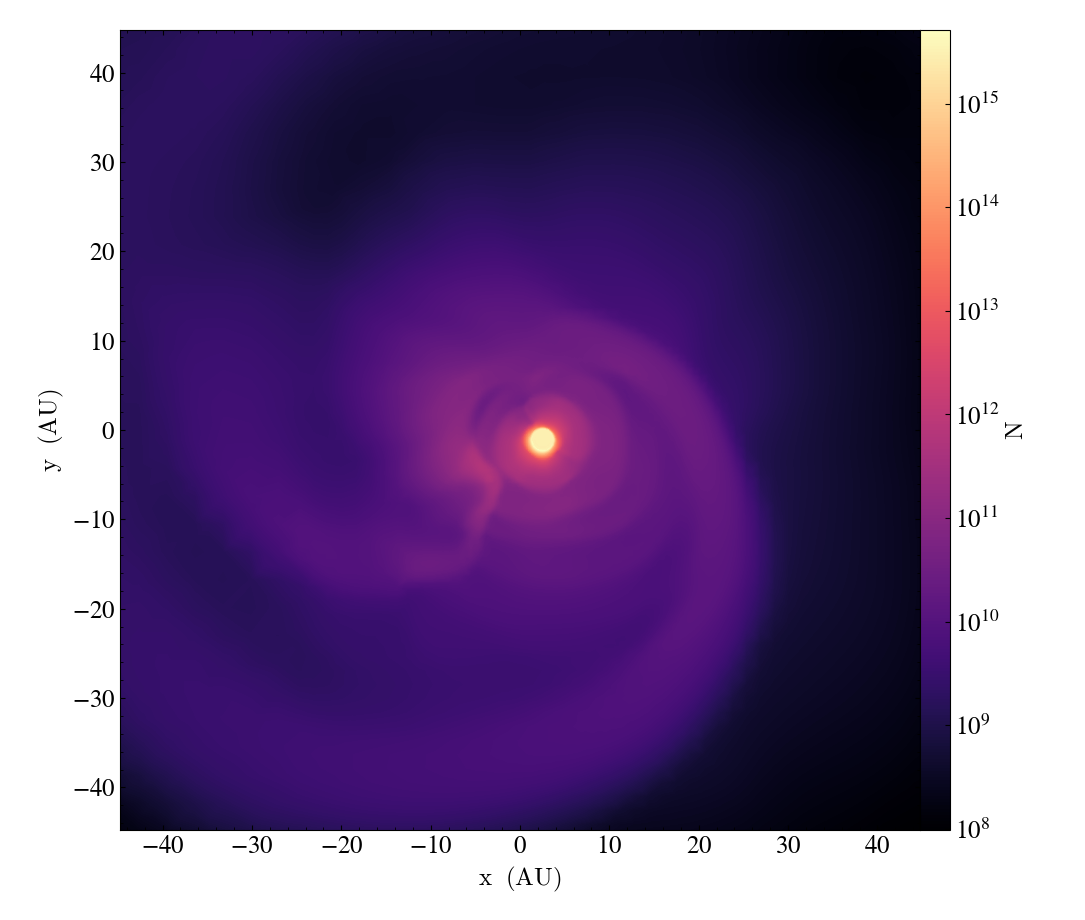

In [10]:
sl = yt.SlicePlot      (ds, 'z', 'n')
sl.set_cmap            ('n', 'magma')
sl.zoom                (1.2)


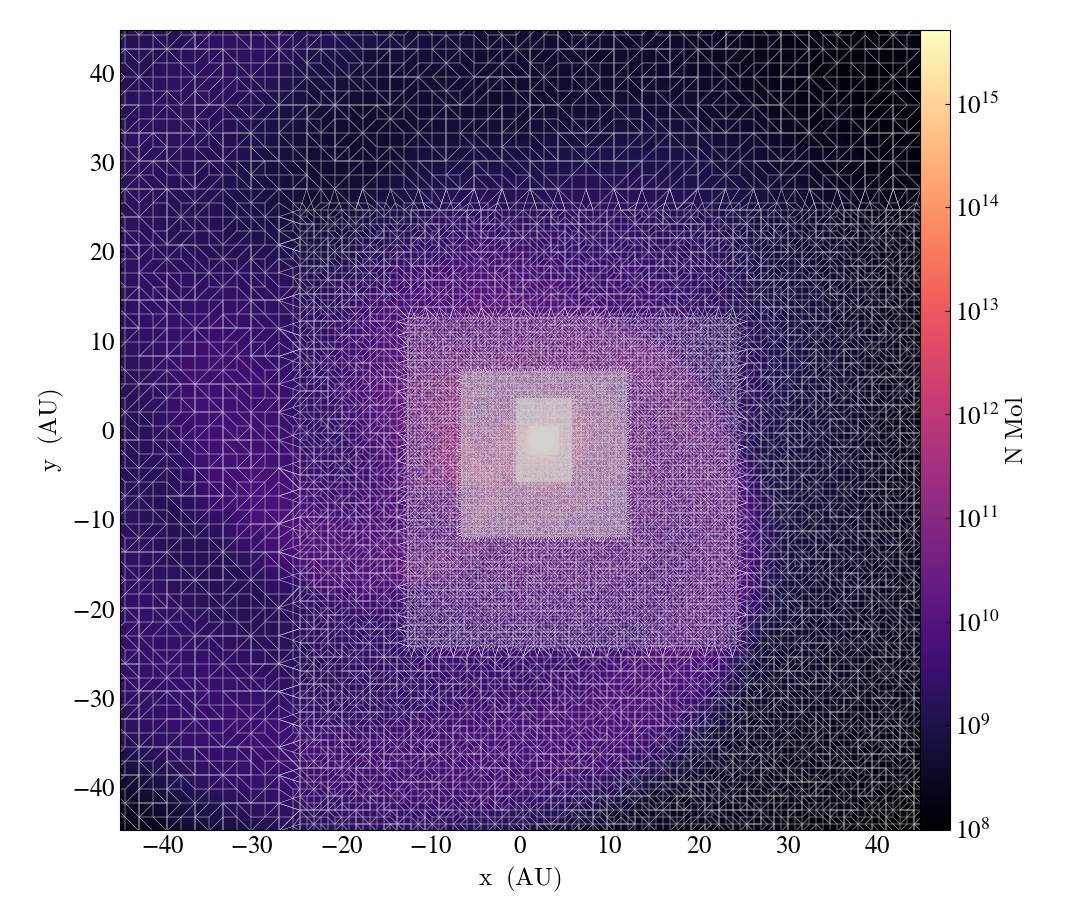

In [10]:
sl = yt.SlicePlot      (ds, 'z', 'n_mol')
sl.set_cmap            ('n_mol', 'magma')
sl.zoom                (1.2)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.2]})